In [ ]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-dl2ss47k
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-dl2ss47k
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.2 MB/s eta 0:00:00
  Created wheel for glide-text2im: filename=glide_text2im-0.0.0-py3-none-any.whl size=1953625 sha256=aa6ecff9fa209c385cd032b6ab787975b04795b802f2613b5ab6376f037281df
  Stored in directory: /tmp/pip-ephem-wheel-cache-y5kjiwlv/wheels/88/21/5e/57cab1c1078317022fe11d86e1596fdaa12260531220ac0c99
Successfully built glide-text2im


In [28]:
from PIL import Image
from IPython.display import display
import numpy as np
import torch as th
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [ ]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
has_cuda = device.type == 'cuda'

In [ ]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100'
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


In [ ]:
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27'  # Use 27 diffusion steps for very fast sampling

# Create and configure the upsampler model
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()

if has_cuda:
    model_up.convert_to_fp16()

# Move model to device and load state dict
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))

# Count total upsampler parameters efficiently
total_params = sum(p.numel() for p in model_up.parameters())
print('Total upsampler parameters:', total_params)


  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

Total upsampler parameters: 398361286


In [ ]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1) * 127.5).round().clamp(0, 255).to(th.uint8).cpu()

    # Reshape tensors and convert to numpy array
    reshaped = scaled.permute(0, 2, 3, 1).reshape(-1, scaled.size(2), 3)
    reshaped_np = reshaped.numpy()

    # Convert to uint8 and create PIL Image
    reshaped_uint8 = np.clip(reshaped_np, 0, 255).astype(np.uint8)
    pil_image = Image.fromarray(reshaped_uint8)

    # Display the image
    display(pil_image)


In [26]:
#@title Image Processing function

def text2image(image_description,batch_size):
  # Sampling parameters
  # image_description = "dog in the field" #@param {type:"string"}
  # image_description = ""
  #batch_size = 1 #@param {type:"integer"}
  guidance_scale = 8.0

  # Tune this parameter to control the sharpness of 256x256 images.
  # A value of 1.0 is sharper, but sometimes results in grainy artifacts.
  upsample_temp = 0.997

  ##############################
  # Sample from the base model #
  ##############################

  # Create the text tokens to feed to the model. These lines tokenize the input image_description using the model's tokenizer and create a mask for the tokens.
  tokens = model.tokenizer.encode(image_description)
  tokens, mask = model.tokenizer.padded_tokens_and_mask(
      tokens, options['text_ctx']
  )

  # Create the classifier-free guidance tokens (empty).
  # Here, "classifier-free guidance tokens" are created. This likely means tokens used for guiding the model during image generation, and in this case, they are empty.
  full_batch_size = batch_size * 2
  uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
      [], options['text_ctx']
  )

  # Pack the tokens together into model kwargs.
  # These lines pack the tokens and masks into a dictionary model_kwargs, which will be used as input to the model for image generation.
  model_kwargs = dict(
      tokens=th.tensor(
          [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size + [uncond_mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),
  )

  # Create a classifier-free guidance sampling function
  # This defines a function model_fn that specifies how to sample images from the model. It computes various operations on the model's output.
  def model_fn(x_t, ts, **kwargs):
      half = x_t[: len(x_t) // 2]
      combined = th.cat([half, half], dim=0)
      model_out = model(combined, ts, **kwargs)
      eps, rest = model_out[:, :3], model_out[:, 3:]
      cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
      half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
      eps = th.cat([half_eps, half_eps], dim=0)
      return th.cat([eps, rest], dim=1)

  # Sample from the base model.
  # This defines a function model_fn that specifies how to sample images from the model.
  #  It computes various operations on the model's output.
  model.del_cache()
  samples = diffusion.p_sample_loop(
      model_fn,
      (full_batch_size, 3, options["image_size"], options["image_size"]),
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model.del_cache()

  # Show the output. The generated images are displayed using the show_images function.
  show_images(samples)


  ##############################
  # Upsample the 64x64 samples #
  ##############################

  tokens = model_up.tokenizer.encode(image_description)   # This section tokenizes the image_description for the upsampling model and creates masks.
  tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
      tokens, options_up['text_ctx']
  )

  # Create the model conditioning dict.
  # Here, a dictionary model_kwargs is created to condition the upsampling model. It includes the low-resolution images (low_res), tokens, and masks.
  model_kwargs = dict(
      # Low-res image to upsample.
      low_res=((samples+1)*127.5).round()/127.5 - 1,

      # Text tokens
      tokens=th.tensor(
          [tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),
  )

  # Sample from the base model.
  # This section samples images from the upsampling model using the ddim_sample_loop function.
  # The generated images are stored in the image variable.
  model_up.del_cache()
  up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
  image = diffusion_up.ddim_sample_loop(
      model_up,
      up_shape,
      noise=th.randn(up_shape, device=device) * upsample_temp,
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model_up.del_cache()

  # Show the output. The upsampled images are displayed using the show_images function, and the generated images are returned by the function.
  show_images(image)
  return image

  0%|          | 0/100 [00:00<?, ?it/s]

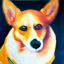

  0%|          | 0/27 [00:00<?, ?it/s]

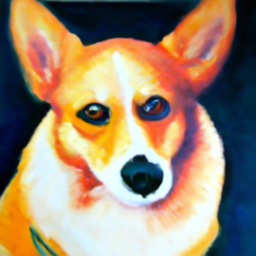

tensor([[[[-0.9336, -0.9343, -0.9445,  ..., -0.9880, -0.9913, -0.9830],
          [-0.9315, -0.9338, -0.9464,  ..., -0.9858, -0.9891, -0.9845],
          [-0.9387, -0.9381, -0.9491,  ..., -0.9861, -0.9871, -0.9867],
          ...,
          [ 0.5703,  0.5713,  0.5578,  ..., -1.0000, -0.9987, -1.0000],
          [ 0.5930,  0.5968,  0.5845,  ..., -0.9977, -1.0000, -1.0000],
          [ 0.6166,  0.6282,  0.6240,  ..., -0.9937, -0.9973, -1.0000]],

         [[-0.7956, -0.8021, -0.8137,  ..., -0.9630, -0.9612, -0.9617],
          [-0.8026, -0.8137, -0.8167,  ..., -0.9658, -0.9605, -0.9600],
          [-0.8070, -0.8157, -0.8230,  ..., -0.9676, -0.9659, -0.9651],
          ...,
          [ 0.4000,  0.4303,  0.4572,  ..., -0.5211, -0.5185, -0.5170],
          [ 0.3690,  0.4020,  0.4394,  ..., -0.5288, -0.5228, -0.5271],
          [ 0.3562,  0.3876,  0.4313,  ..., -0.5280, -0.5245, -0.5262]],

         [[-0.7295, -0.7354, -0.7327,  ..., -0.9727, -0.9728, -0.9750],
          [-0.7353, -0.7430, -

In [29]:
#Sampling parameters
prompt = "an oil painting of a corgi"
batch_size = 1


text2image(prompt, batch_size)

In [ ]:
!pip install fastapi uvicorn

In [ ]:
from fastapi import FastAPI

app = FastAPI()

# Mocking the text2image function for demonstration purposes
def text2image(prompt, batch_size, scale):
  # Sampling parameters
  # image_description = "dog in the field" #@param {type:"string"}
  # image_description = ""
  #batch_size = 1 #@param {type:"integer"}
  guidance_scale = 8.0

  # Tune this parameter to control the sharpness of 256x256 images.
  # A value of 1.0 is sharper, but sometimes results in grainy artifacts.
  upsample_temp = 0.997

  ##############################
  # Sample from the base model #
  ##############################

  # Create the text tokens to feed to the model. These lines tokenize the input image_description using the model's tokenizer and create a mask for the tokens.
  tokens = model.tokenizer.encode(image_description)
  tokens, mask = model.tokenizer.padded_tokens_and_mask(
      tokens, options['text_ctx']
  )

  # Create the classifier-free guidance tokens (empty).
  # Here, "classifier-free guidance tokens" are created. This likely means tokens used for guiding the model during image generation, and in this case, they are empty.
  full_batch_size = batch_size * 2
  uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
      [], options['text_ctx']
  )

  # Pack the tokens together into model kwargs.
  # These lines pack the tokens and masks into a dictionary model_kwargs, which will be used as input to the model for image generation.
  model_kwargs = dict(
      tokens=th.tensor(
          [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size + [uncond_mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),
  )

  # Create a classifier-free guidance sampling function
  # This defines a function model_fn that specifies how to sample images from the model. It computes various operations on the model's output.
  def model_fn(x_t, ts, **kwargs):
      half = x_t[: len(x_t) // 2]
      combined = th.cat([half, half], dim=0)
      model_out = model(combined, ts, **kwargs)
      eps, rest = model_out[:, :3], model_out[:, 3:]
      cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
      half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
      eps = th.cat([half_eps, half_eps], dim=0)
      return th.cat([eps, rest], dim=1)

  # Sample from the base model.
  # This defines a function model_fn that specifies how to sample images from the model.
  #  It computes various operations on the model's output.
  model.del_cache()
  samples = diffusion.p_sample_loop(
      model_fn,
      (full_batch_size, 3, options["image_size"], options["image_size"]),
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model.del_cache()

  # Show the output. The generated images are displayed using the show_images function.
  show_images(samples)


  ##############################
  # Upsample the 64x64 samples #
  ##############################

  tokens = model_up.tokenizer.encode(image_description)   # This section tokenizes the image_description for the upsampling model and creates masks.
  tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
      tokens, options_up['text_ctx']
  )

  # Create the model conditioning dict.
  # Here, a dictionary model_kwargs is created to condition the upsampling model. It includes the low-resolution images (low_res), tokens, and masks.
  model_kwargs = dict(
      # Low-res image to upsample.
      low_res=((samples+1)*127.5).round()/127.5 - 1,

      # Text tokens
      tokens=th.tensor(
          [tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),
  )

  # Sample from the base model.
  # This section samples images from the upsampling model using the ddim_sample_loop function.
  # The generated images are stored in the image variable.
  model_up.del_cache()
  up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
  image = diffusion_up.ddim_sample_loop(
      model_up,
      up_shape,
      noise=th.randn(up_shape, device=device) * upsample_temp,
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model_up.del_cache()

  # Show the output. The upsampled images are displayed using the show_images function, and the generated images are returned by the function.
  show_images(image)
  return f"Generating images for prompt '{prompt}' with batch size {batch_size} and scale {scale}"

@app.post("/generate_images/")
async def generate_images(input_prompt: str, batch_size: int, guidance_scale: float):
    result = text2image(input_prompt, batch_size, guidance_scale)
    return {"result": result}
